# Metrics sensitivity to magnitude of pulse emission

The purpose of this notebook is to assess the sensitivity of the metrics values to varying magntiudes of pulse emissions. The pulse emissions are varied in the range $[1 - 10^k]$ kilograms, with $k = 16$.

In [6]:
# Import librairies
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Climate functions
from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.co2_ipcc_climate_model import CO2_IPCC_ClimateModel
from aerometrics.climate_models.gwpstar_climate_model import GWPStarClimateModel
from aerometrics.climate_models.lwe_climate_model import LWEClimateModel
from aerometrics.climate_models.fair_climate_model import FairClimateModel

## Parameters

In [7]:
# Set parameters
co2_method = 'FaIR'
start_year = 1765
t0 = 2020
time_horizon = 100
end_year = t0 + time_horizon

species_settings = {
    "CO2": {"ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
    "Contrails": {"sensitivity_rf": 2.23e-12, "ratio_erf_rf": 0.42, "efficacy_erf": 1.0},
    "NOx - ST O3 increase": {"sensitivity_rf": 25.1e-12 * (14/46), "ratio_erf_rf": 1.37, "efficacy_erf": 1.0},
    "NOx - CH4 decrease and induced": {"ch4_loss_per_nox": -3.90, "ratio_erf_rf": 1.18, "efficacy_erf": 1.0},
    "H2O": {"sensitivity_rf": 0.0052e-12, "ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
    "Soot": {"sensitivity_rf": 100.7e-12, "ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
    "Sulfur": {"sensitivity_rf": -19.9e-12, "ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
}

model_settings = {"rcp": "RCP45"}

## Metrics calculation

In [8]:
# Set maximum value for k
decade_number = 16  # Numerical problem for CO2 after this level of emissions

# Initialise vectors to store values
gwp_rf = np.zeros((decade_number,7))
gwp_erf = np.zeros((decade_number,7))
egwp_rf = np.zeros((decade_number,7))
egwp_erf = np.zeros((decade_number,7))
gtp = np.zeros((decade_number,7))
igtp = np.zeros((decade_number,7))
ratr = np.zeros((decade_number,7))

# Calculate metrics for all species
for j, species in enumerate(["CO2", "Contrails", "NOx - ST O3 increase", "NOx - CH4 decrease and induced", "H2O", "Soot", "Sulfur"]):

    # Calculate metrics for varying magnitudes of pulse emissions (magnitude = 10^k kilograms)
    for k in range(0,decade_number):
        unit_value = 1*10**k # [kg] or [km] for contrails
        emission_profile = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)

        # CO2 absolute metrics
        if co2_method == 'IPCC':
           agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            results_co2 = FairClimateModel(
                start_year,
                end_year,
                "CO2",
                emission_profile,
                species_settings["CO2"],
                model_settings
            ).run()
            radiative_forcing_co2_unit = results_co2["radiative_forcing"] / unit_value
            effective_radiative_forcing_co2_unit = results_co2["effective_radiative_forcing"] / unit_value
            temperature_co2_unit = results_co2["temperature"] / unit_value
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(
                radiative_forcing_co2_unit, 
                effective_radiative_forcing_co2_unit, 
                species_settings["CO2"].get("efficacy_erf", 1.0), 
                temperature_co2_unit, 
                time_horizon
            )

        # Species absolute metrics
        emission_profile = emission_profile_function(start_year, t0, time_horizon, 'pulse', unit_value)
        results = FairClimateModel(
            start_year,
            end_year,
            species,
            emission_profile,
            species_settings[species],
            model_settings
        ).run()
        
        radiative_forcing_unit = results["radiative_forcing"] / unit_value
        effective_radiative_forcing_unit = results["effective_radiative_forcing"] / unit_value
        temperature_unit = results["temperature"] / unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(
            radiative_forcing_unit, 
            effective_radiative_forcing_unit, 
            species_settings[species].get("efficacy_erf", 1.0), 
            temperature_unit, 
            time_horizon
        )

        #  Relative metrics
        gwp_rf[k,j], gwp_erf[k,j], egwp_rf[k,j], egwp_erf[k,j], gtp[k,j], igtp[k,j], ratr[k,j] = relative_metrics(
            agwp_rf_co2, 
            agwp_erf_co2, 
            aegwp_rf_co2, 
            aegwp_erf_co2, 
            agtp_co2, 
            iagtp_co2, 
            atr_co2, 
            agwp_rf, 
            agwp_erf, 
            aegwp_rf, 
            aegwp_erf, 
            agtp, 
            iagtp, 
            atr
        )

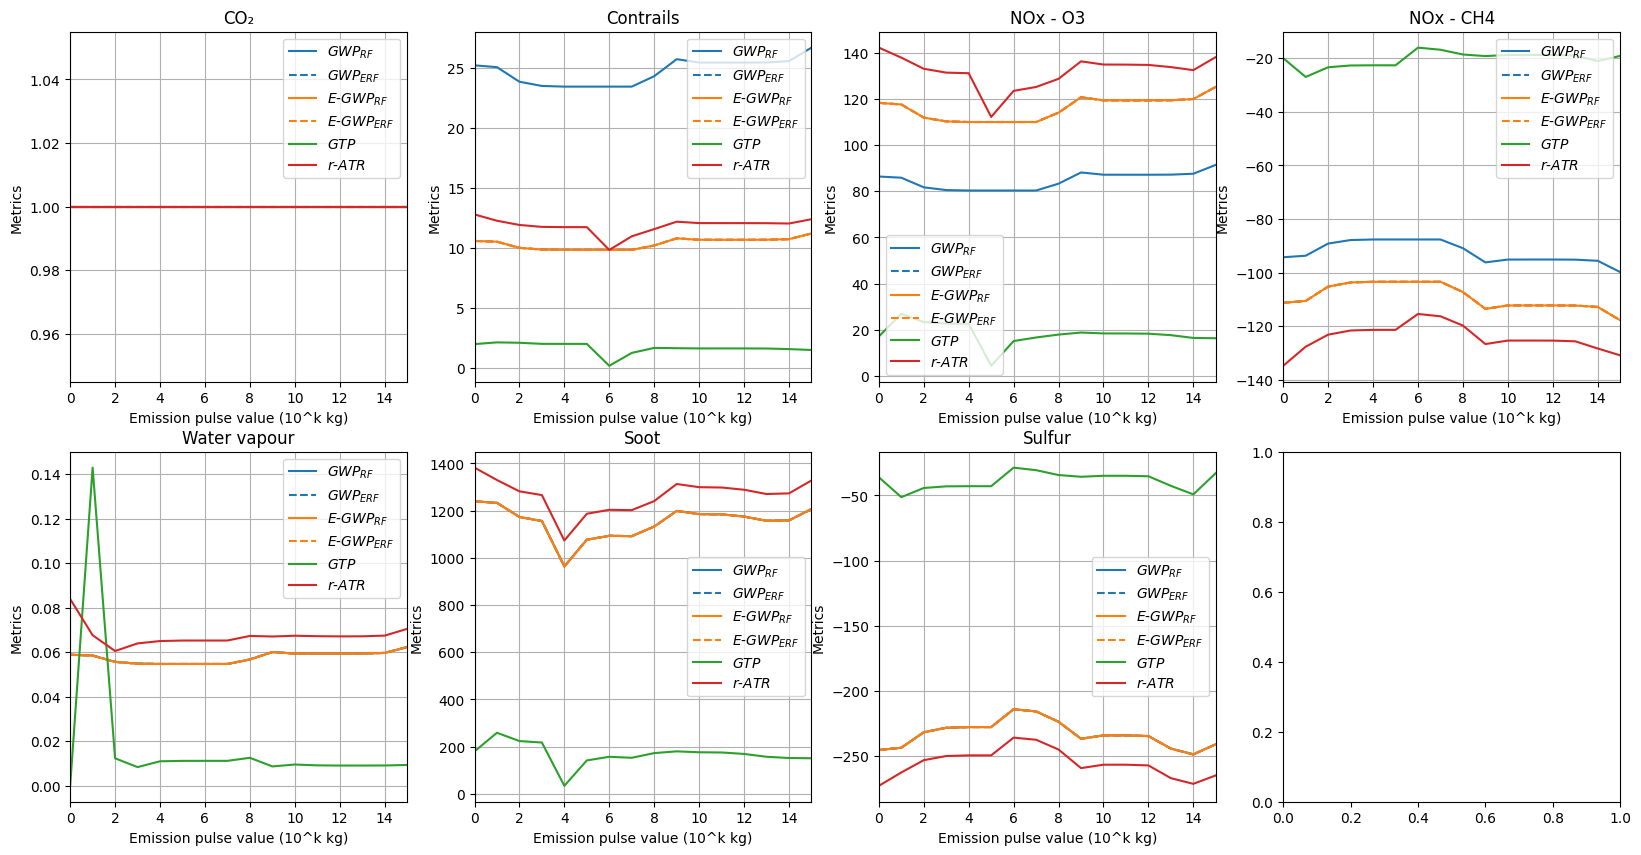

In [9]:
# Plot results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i != 7:
        x_axis = range(0, len(gwp_rf[:, i]))
        ax.plot(x_axis, gwp_rf[:, i], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, gwp_erf[:, i], label=r'$GWP_{ERF}$', color='C0', linestyle='--')
        ax.plot(x_axis, egwp_rf[:, i], label=r'$E\text{-}GWP_{RF}$', color='C1')
        ax.plot(x_axis, egwp_erf[:, i], label=r'$E\text{-}GWP_{ERF}$', color='C1', linestyle='--')
        ax.plot(x_axis, gtp[:, i], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratr[:, i], label=r'$r\text{-}ATR$', color='C3')
        ax.set_xlim(0,len(gwp_rf[:, i])-1)
        ax.set_xlabel('Emission pulse value (10^k kg)')
        ax.set_ylabel('Metrics')
        if i == 0:
            ax.set_title('CO₂')
        elif i == 1:
            ax.set_title('Contrails')
        elif i == 2:
            ax.set_title('NOx - O3')
        elif i == 3:
            ax.set_title('NOx - CH4')
        elif i == 4:
            ax.set_title('Water vapour')
        elif i == 5:
            ax.set_title('Soot')
        elif i == 6:
            ax.set_title('Sulfur')
        ax.grid()
        ax.legend()
    
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()